# *Deep Learning on LandCover.ai dataset*
# 1. Data description & preparation <a name="1"></a>
## 1.1 Data Visualizations <a name="1.1"></a>
The dataset that we utilize in this notebook is the LandCover.ai as presented in [[1]](#ref1). The dataset consists of 41 orthophoto tiles from different counties located in Poland. Every tile has about 5 km$^2$. There are 33 images with resolution 25 cm (ca. 9000 x 9500 px) and 8 images with resolution 50 cm (ca. 4200 x 4700 px), which gives 176.76 km$^2$ and 39.51 km$^2$ respectively resutling in 216.27 km$^2$ coverage in total. Below you can see some samples from the dataset.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/landcoverai/val.txt
/kaggle/input/landcoverai/test.txt
/kaggle/input/landcoverai/train.txt
/kaggle/input/landcoverai/split.py
/kaggle/input/landcoverai/images/M-34-77-B-c-2-3.tif
/kaggle/input/landcoverai/images/N-33-139-C-d-2-2.tif
/kaggle/input/landcoverai/images/M-34-51-C-d-4-1.tif
/kaggle/input/landcoverai/images/N-34-97-C-b-1-2.tif
/kaggle/input/landcoverai/images/M-34-65-D-a-4-4.tif
/kaggle/input/landcoverai/images/N-33-130-A-d-3-3.tif
/kaggle/input/landcoverai/images/M-34-65-D-c-4-2.tif
/kaggle/input/landcoverai/images/N-33-130-A-d-4-4.tif
/kaggle/input/landcoverai/images/N-34-77-A-b-1-4.tif
/kaggle/input/landcoverai/images/N-34-106-A-c-1-3.tif
/kaggle/input/landcoverai/images/M-34-68-B-a-1-3.tif
/kaggle/input/landcoverai/images/M-34-32-B-a-4-3.tif
/kaggle/input/landcoverai/images/N-33-60-D-c-4-2.tif
/kaggle/input/landcoverai/images/M-34-55-B-b-4-1.tif
/kaggle/input/landcoverai/images/M-33-7-A-d-2-3.tif
/kaggle/input/landcoverai/images/N-33-96-D-d-1-1.tif
/kaggle/i

In [2]:
!pip install segmentation-models-pytorch --quiet
import segmentation_models_pytorch as smp

In [3]:
import warnings
warnings.filterwarnings("ignore")
import cv2
import glob
import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from utils import SegmentationDataset
from utils import segmentation_test_loop
from utils import class_report
from utils import visualize_preds
from utils import split_images
from utils import training_loop
from utils import visualize_dataset
from utils import visualize_tif
from utils import UNet
import albumentations as A
sns.set_style("dark")

device = "cuda" if torch.cuda.is_available() else "cpu"
DATA_ROOT = "../input/landcoverai"

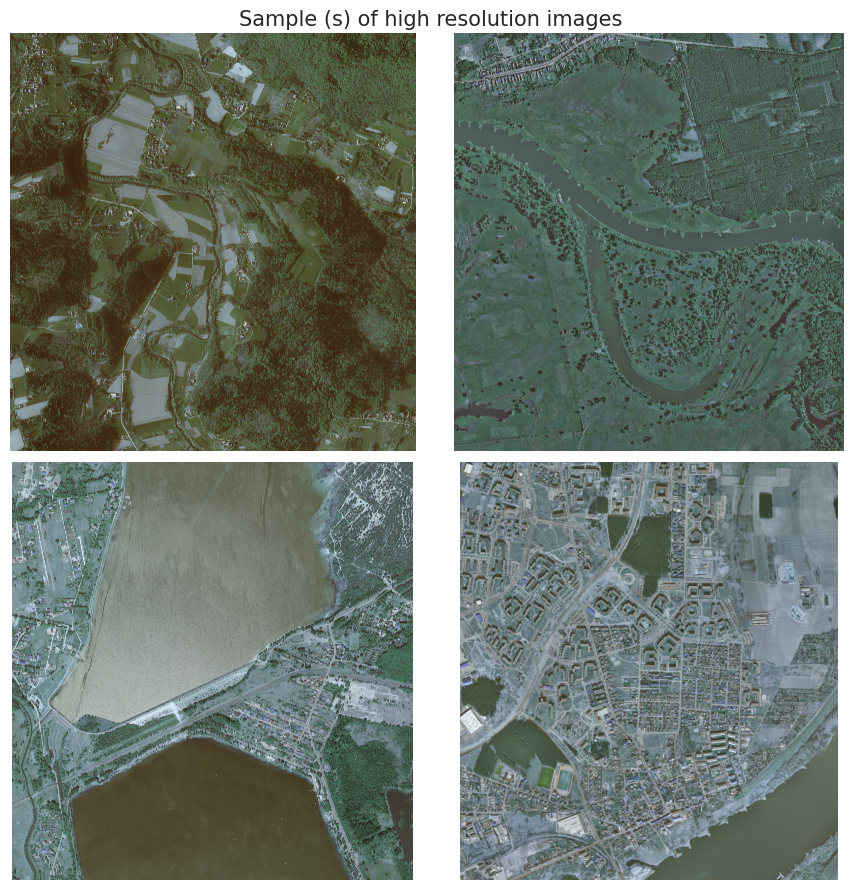

In [4]:
images_list = list(glob.glob(os.path.join(DATA_ROOT, "images", "*.tif")))
samples = [0,1,2,3]
fig, ax = plt.subplots(figsize = (9,9), nrows = 2, ncols =2)
for i, sample in enumerate(samples):
    r,c = divmod(i,2)
    ax[r,c].imshow(cv2.imread(images_list[sample])/255)
    ax[r,c].axis("off")
plt.suptitle("Sample (s) of high resolution images", fontsize = 15)
plt.tight_layout(pad=0.8)
plt.savefig("Samples.png")
plt.show()

The annotations of the dataset have been manually created with the VGG Image Annotator (VIA) [[2]](#ref2). The creators of the dataset provide the corresponding masks for the images. There are 5 classes in total:

<h4><center>The different land uses of the dataset</center></h4>

| **Class** | **Coverage (km$^2$)** | **Label** |
|:---------------|:-----------------|:-----------------|
| **Background** |       **125.75**     |       **0**     |
| **Building** |       **1.85**     |       **1**     |
| **Woodland** |       **72.02**     |       **2**     |
| **Water** |       **13.15**     |       **3**     |
| **Road** |       **3.5**     |       **4**     |

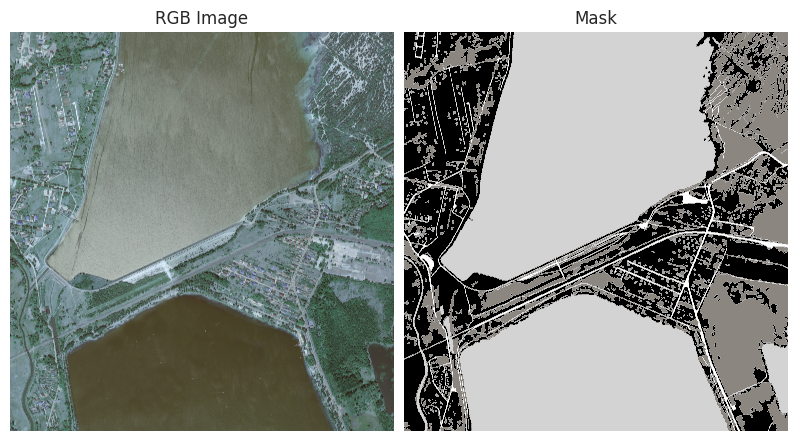

In [5]:
# Index = n corresponds to the n-th tif file in order located in "images" file"""
visualize_tif(h = 8, w = 8, index = 2, save_title = "VisualizeTif") 

## 1.2 Image Cropping <a name="1.2"></a>

The large size of the images (~ 9000 x 9000) is prohibitive in order to train a deep neural network. This mainly due to the limited GPU resources available. The authors in [[1]](#ref1) split the images and their corresponding masks into 512 x 512 tiles and they use the 70, 15, 15 % of them as training, validation and test sets. Moreover, they provide lists of filenames with the images contained in the all the aforementioned datasets. In this way, new users of the dataset will be able to test their models on the same sets and compare their results with the benchmark results.

We create a custom function named `split_images` to wrap the splitting module into a function. The only argument of the function is the size of the resulting squared images (default is set to 512). Below we split the images by using the custom function and save the results into a folder named output.

### 1.2.1 Squared images of size 512 <a name="1.2.1"></a>

In this subsection we split the images into smaller images of size 512x512. Furthermore, we provide some statistical properties of the resulting dataset. Below you can see some samples of the obtained dataset using the custom function `visualize_dataset`.

In [6]:
IMAGE_SIZE = 512
split_images(TARGET_SIZE = IMAGE_SIZE)

Splitting the images...

Processed M-33-20-D-c-4-2 1/41
Processed M-33-20-D-d-3-3 2/41
Processed M-33-32-B-b-4-4 3/41
Processed M-33-48-A-c-4-4 4/41
Processed M-33-7-A-d-2-3 5/41
Processed M-33-7-A-d-3-2 6/41
Processed M-34-32-B-a-4-3 7/41
Processed M-34-32-B-b-1-3 8/41
Processed M-34-5-D-d-4-2 9/41
Processed M-34-51-C-b-2-1 10/41
Processed M-34-51-C-d-4-1 11/41
Processed M-34-55-B-b-4-1 12/41
Processed M-34-56-A-b-1-4 13/41
Processed M-34-6-A-d-2-2 14/41
Processed M-34-65-D-a-4-4 15/41
Processed M-34-65-D-c-4-2 16/41
Processed M-34-65-D-d-4-1 17/41
Processed M-34-68-B-a-1-3 18/41
Processed M-34-77-B-c-2-3 19/41
Processed N-33-104-A-c-1-1 20/41
Processed N-33-119-C-c-3-3 21/41
Processed N-33-130-A-d-3-3 22/41
Processed N-33-130-A-d-4-4 23/41
Processed N-33-139-C-d-2-2 24/41
Processed N-33-139-C-d-2-4 25/41
Processed N-33-139-D-c-1-3 26/41
Processed N-33-60-D-c-4-2 27/41
Processed N-33-60-D-d-1-2 28/41
Processed N-33-96-D-d-1-1 29/41
Processed N-34-106-A-b-3-4 30/41
Processed N-34-106-A

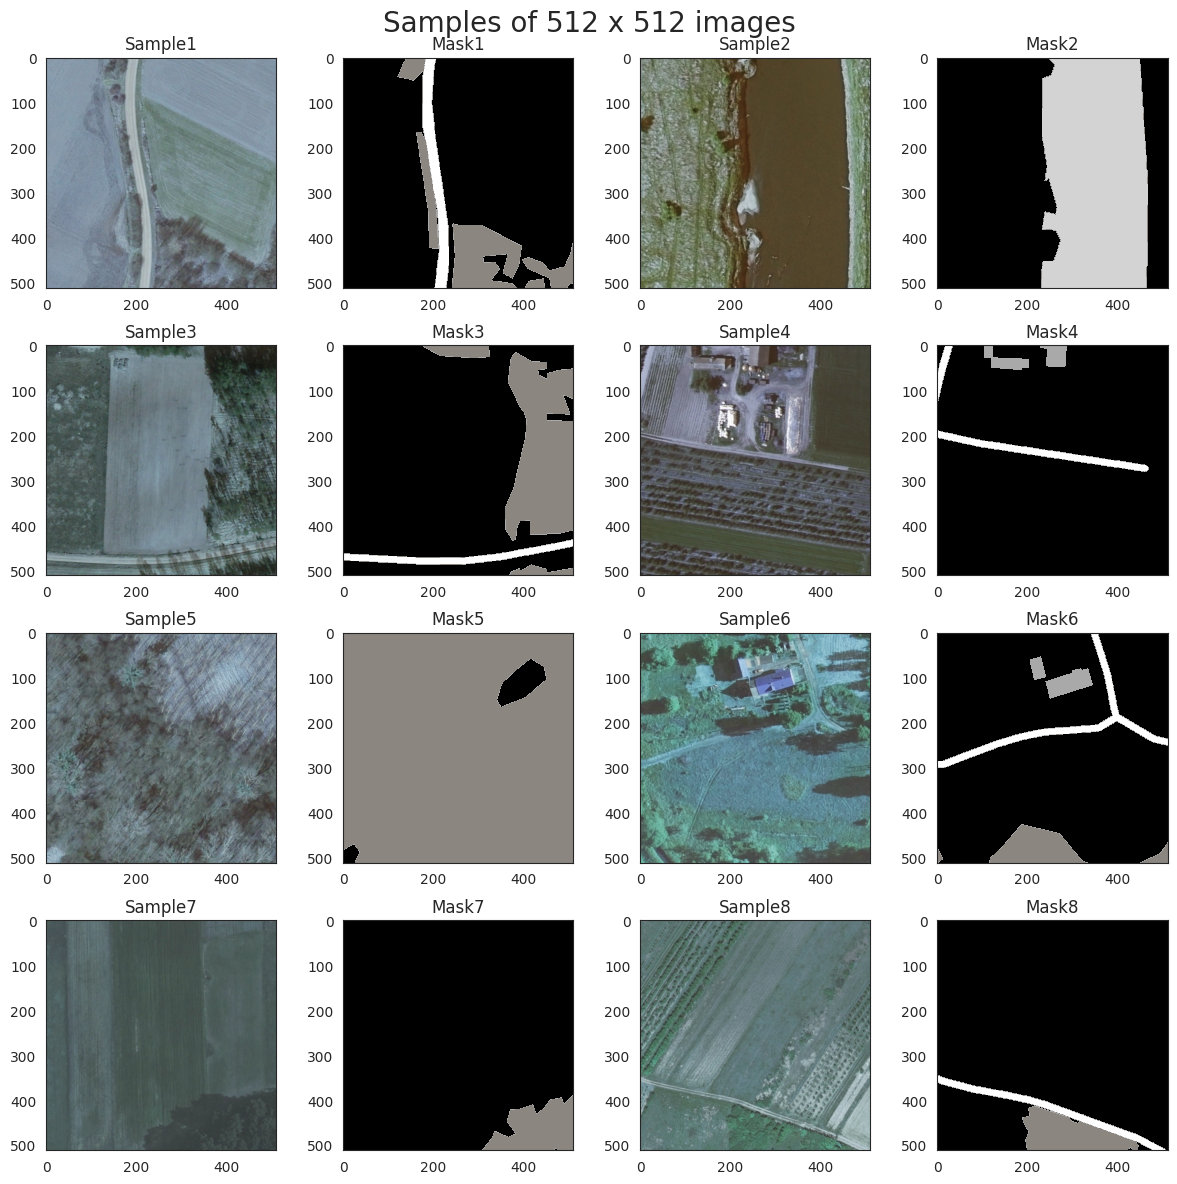

In [7]:
visualize_dataset(num_samples = 8, w = 12, h = 12, pad = 1.4,
                 save_title = "Visualize_dataset", indices = [0,1,17,20,29,5,6,7])

Since background covers about 125 km$^2$ and woodlands 72 km$^2$ we see that the dataset is highly unbalanced. As will shall shortly see the fact that background & woodland covers most of the pixels poses a great challenge to the development of a model that recognizes the other areas. In our cases, the hardest pixels to classify are the pixels corresponding to roads and buildings. To tackle this problem we develop several mechanisms, some of them have to do with the architecture of the model, the loss function or the chosen regularizations during the training procedure. 

Below you can see the exact pixels corresponding to each class for the training set in the case of the 512 x 512 images. In order to find the distribution of the training test we construct a custom class named `SegmentationDataset`. This class will be used also to train and validate the models in the next sections. It inherits from the `nn.Module`, the arguments is variable `mode` which corresponds to the txt file to be read, i.e. "train.txt", "val.txt", "test.txt". The argument `ratio` which corresponds to the total ratio of the given dataset (either train,val or test) to be used. For example, if `mode = "train"` and `ratio = 0.5` then the 50% of the whole training set will be used. The argumennt `transforms` which corresponds to the transformations that we will use in the next subsections to augment the training set for better performance.

In [8]:
train_set = SegmentationDataset(mode = "train")
train_dloader = DataLoader(train_set,batch_size = 8,num_workers =2)

class_dist = {
    "background":0, 
    "building":0,
    "woodland":0, 
    "water":0, 
    "road":0
}
label_mapping = {
    0: "background", 
    1: "building",
    2: "woodland", 
    3: "water", 
    4: "road"
}

for img,mask in train_dloader:
    for class_label in label_mapping.keys():
        class_dist[label_mapping[class_label]] += mask[mask == class_label].numpy().size

Using the whole train set --> 7470


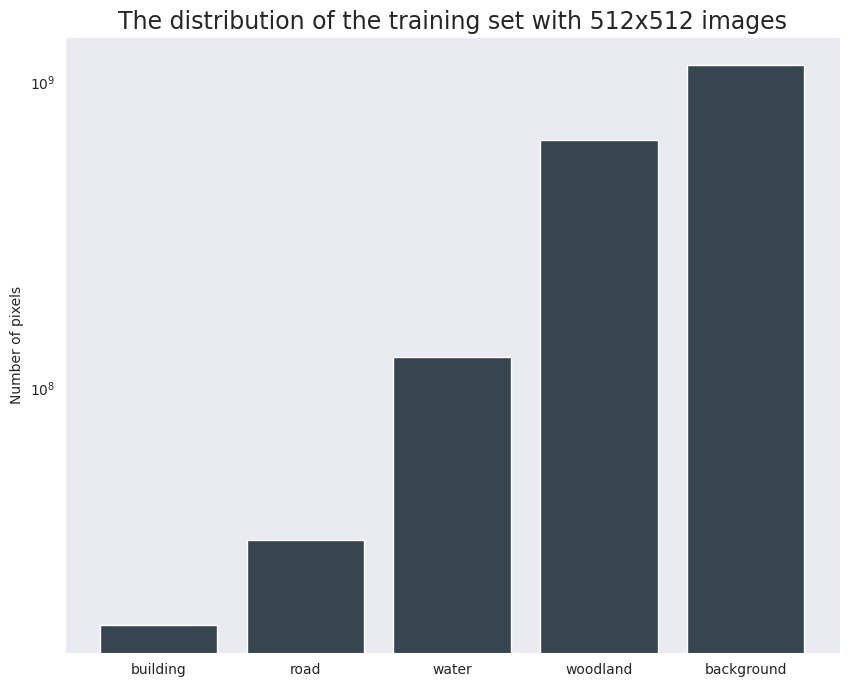

In [9]:
temp_list = sorted([(l,s) for (l,s) in class_dist.items()], key= lambda x: x[1])
labels = [x[0] for x in temp_list]
support = [x[1] for x in temp_list]

sns.set_style("dark")
fig, ax = plt.subplots(figsize = (10,8))
ax.bar(labels, support, color = "#36454F")
ax.set_yscale("log")
ax.set_title("The distribution of the training set with 512x512 images",
            fontsize = 17)
ax.set_ylabel("Number of pixels")
plt.savefig("Barplt.png")
plt.show()

## 1.2 Data Augmentation <a name="1.2"></a>

A common technique to enhance the predictive power of a model by avoiding overfitting and the class unbalance of the dataset is to use data augmentations. In this notebook we use [Albumentations](https://albumentations.ai) library to enhance our training set by using a series of transformations. The idea behind data augmentation in this case is to produce images corresponding to different flights and diverse land cover conditions and time seasons. The transformations are defined by the argument `transforms` in the `SegmentationDataset` class located in utils.py. Below you can see the data augmentations that we will use in the largest training set (corresponding to 512x512 images).

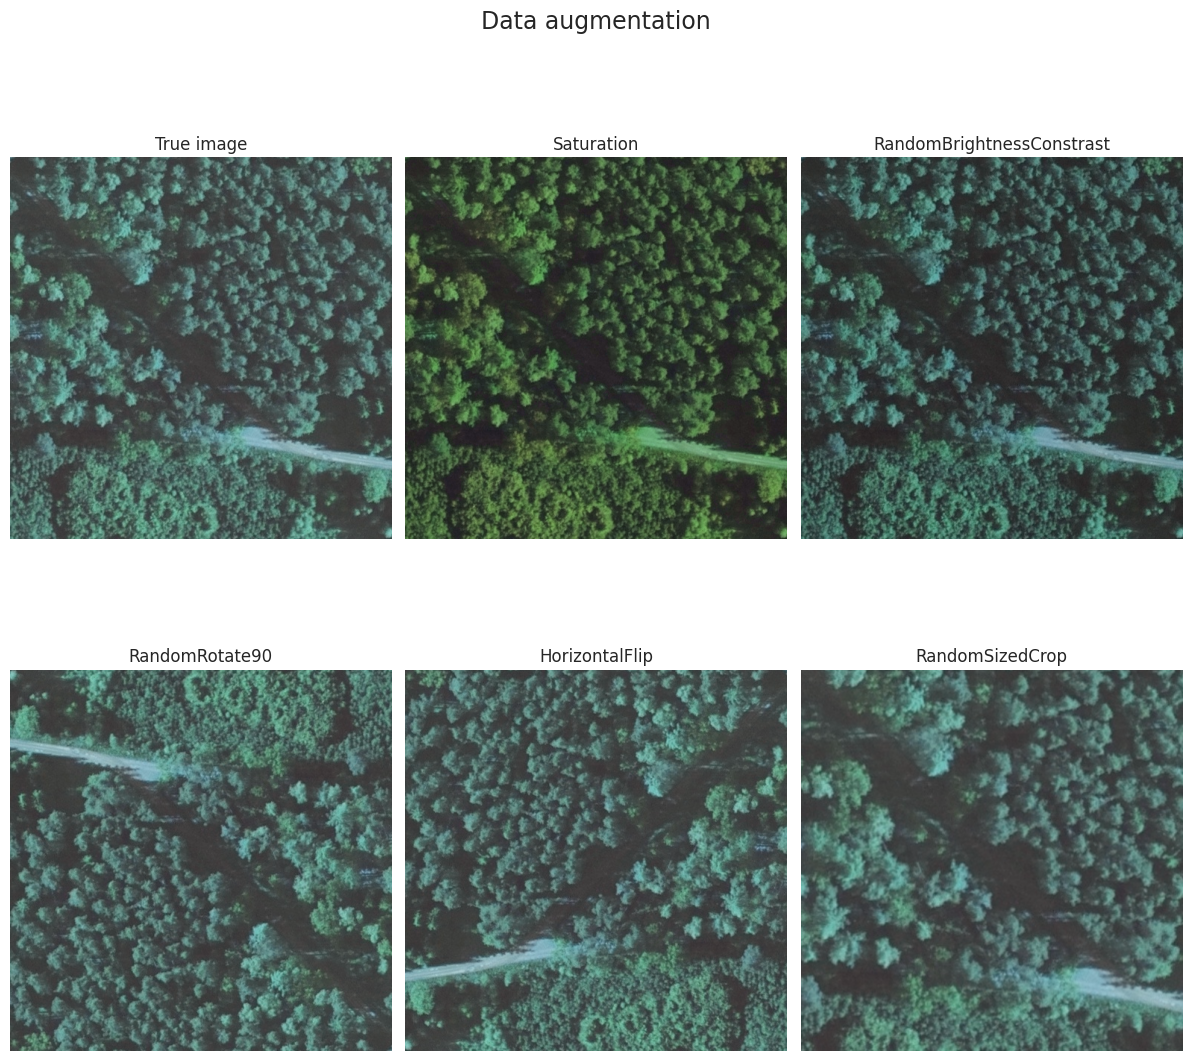

In [10]:
# Transformations
transforms = [A.HueSaturationValue(40,40,30,p=1),
             A.RandomBrightnessContrast(p=1,brightness_limit = 0.2, contrast_limit = 0.5),
             A.RandomRotate90(p=1), A.HorizontalFlip(p=1), 
              A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)]
transforms_names = ["Saturation", "RandomBrightnessConstrast",
                   "RandomRotate90", "HorizontalFlip", "RandomSizedCrop"]

# Read the NUM_SAMPLE sample in the training set
NUM_SAMPLE = 4
trainpath_list = list(glob.glob(os.path.join(os.getcwd(),"output", "*.jpg")))
img = cv2.imread(trainpath_list[NUM_SAMPLE])

fig, ax = plt.subplots(figsize = (12,12), nrows = 2, ncols = 3)

ax[0,0].imshow(img)
ax[0,0].axis("off")
ax[0,0].set_title("True image")
count = 0

for i in range(2):
    for j in range(3):
        if i+j == 0:
            ax[i,j].imshow(img)
            ax[i,j].axis("off")
            ax[i,j].set_title("True image")
        else:
            transformed_img = transforms[count](image = img)["image"]
            ax[i,j].imshow(transformed_img)
            ax[i,j].axis("off")
            ax[i,j].set_title(transforms_names[count])
            count+=1
plt.suptitle("Data augmentation", fontsize = 17)
plt.tight_layout(pad = 1)
plt.savefig("augmentations.png")
plt.show()

# 2. Reported Benchmarks <a name="2"></a>

In this section we present the reported benchmarks and the various architectures that have been used for the semantic segmentation task on the LandCoverai dataset. The dataset was introduced in [[1]](#ref1) in 2020. Apart from the presentation of the dataset the creators developed a DeepLabv3+ ([[3]](#ref3)) using a modified version of Xception71 [[3,4,5]](#ref3) with Dense Prediction Cell (DPC) [[6]](#ref6) as a backbone. They report an overall Intersection over Union (IoU) (see below for definition) of 85.56% on the test set. In [[7]](#ref7) the authors introduce TorchGeo, a Python package for enabling deep learning geospatial datasets. The implement custom dataloaders for common geospatial datasets and training schemes. They also provide pretrained models on satellite imagery that enables other users or researchers to exploit them for transfer learning in their pipelines. In the LandCover.ai dataset they report a mean IoU of 84.41% using a UNet architecture with a pretrained resnet50 as a backbone. In another approach the authors in [[8]](#ref8) experiment with different techniques and extract different approachs to define backbone structures. They report a mean IoU of 76.6% on LandCover.ai dataset.

# 3. Experiments <a name="3"></a>

## 3.1 Setting the training scheme <a name="3.1"></a>

In this subsection we define the training scheme that we will use throughout this Notebook. The hyperparameters were chosen after experiments which were conducted locally. By no means, the chosen hyperparameters are not the optimal ones since we couldn't perform many experiments due to the GPU limitations. To validate our models we use the Intersection over Union (IoU) metric which is defined as follows: An image mask $y$ can be represented as a 2D array of size $H\times W$. Similarly, on semantic segmentation, we can represent the prediction mask as a 2D array of size $H\times W$. Suppose that $C$ is the number of classes indexed from the set $\{0,1,\dots C-1\}$. Fix an index $0\leq k \leq C-1$. Then, the number of pixels on mask $y$ which is equal to $k$ can be described by the cardinal number of the set $\{(i,j):\, 1\leq i \leq H,\, 1\leq j \leq W,\, y[i,j]=k\}$, i.e.

$$\tag{3.1.1}Y_k:=\bigl|\left\{(i,j):\, 1\leq i \leq H,\, 1\leq j \leq W,\, y[i,j]=k\right\}\bigr|.$$

Similarly, for the prediction mask $y'$ the number of pixels which is equal to $k$ is given by

$$\tag{3.1.2}Y'_k:= \bigl|\left\{(i,j):\, 1\leq i \leq H,\, 1\leq j \leq W,\, y'[i,j]=k\right\}\bigr|.$$

With this notation the intersection over union for the class $k$ on the image with mask $y$ is calculated as

$$\tag{3.1.3} \frac{\bigl|Y_k \cap Y'_k\bigr|}{\bigl|Y_k \cup Y'_k\bigr|},$$

where again by $|A|$ we denote the cardinal number of the set $A$. Observe that the quantity in (3.1.3) is always between $0$ and $1$. Values close to $0$ correspond to zero numerator. In other words, the intersection $|Y_k\cap Y'_k|$ is close to $0$ which means that there are only a few correct predictions. On the other hand, values close to $1$ means that $|Y_k\cap Y'_k| \approx |Y_k \cup Y'_k|$ which in turn implies that almost all predictions are correct. Now, given a finite sequence of images, masks and predictions we denote by $M_k$ the mean value of (3.1.3) for each $0\leq k \leq C-1$ over all masks and predictions of the sequence. Then, the Mean Intersection over Union is given by

$$\tag{3.1.4} IoU = \frac{1}{C}\sum_{k=0}^{C-1}M_{k}.$$

Now, the IoU loss (or Jaccard loss) is calculated by

$$\tag{3.1.5} IoU Loss = 1 - IoU = 1 - \frac{1}{C}\sum_{k=0}^{C-1}M_{k}.$$

Since IoU is the standard metric used for validation on semantic segmentation tasks we use the IoU loss as a loss function to train our models. We use the implementation of Jaccard loss provided by [Segmentation Models Pytorch](https://github.com/qubvel/segmentation_models.pytorch). In this Notebook we will also use some architectures provided by segmentation models PyTorch library. Below we define all the necessary hyperparameters for training and we import the `training_loop` from utils library. Furthermore, we define the series of transformations that we will use in the upcoming training sessions.

In [11]:
# Configuring the set of transformations
transforms = A.Compose([
    A.OneOf([
        A.HueSaturationValue(40,40,30,p=1),
        A.RandomBrightnessContrast(p=1,brightness_limit = 0.2,
                                  contrast_limit = 0.5)], p = 0.5),
    A.OneOf([
        A.RandomRotate90(p=1),
        A.HorizontalFlip(p=1),
        A.RandomSizedCrop(min_max_height=(248,512),height=512,width=512, p =1)
    ], p = 0.5)])

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
target_names = np.array(["background", "building", "woodland", "water", "road"])

# Loss function - Mean IoU loss
loss_fn = smp.losses.JaccardLoss(mode = "multiclass",
                                classes = 5).to(device)

# Hyperparameters
batch_size = 8
epochs = 10
lr = 5e-5

# Preparing datasets and DataLoaders
train_set = SegmentationDataset(mode = "train", transforms = transforms,
                               ratio = 0.6)
test_set = SegmentationDataset(mode = "test")
val_set = SegmentationDataset(mode = "val", ratio = 0.7)

train_dloader = DataLoader(train_set, batch_size = batch_size,
                           shuffle = True, num_workers = 2)
test_dloader = DataLoader(test_set, batch_size = batch_size, num_workers = 2)
val_dloader = DataLoader(val_set, batch_size=batch_size, num_workers = 2)

Using the 60.00% of the initial train set --> 4482|7470
Using the whole test set --> 1602
Using the 70.00% of the initial val set --> 1121|1602


## 3.2 Vanilla UNet <a name="3.2"></a>

In this subsection we train a vanilla UNet model [[9]](#ref9). In the figure below you can see the architecture of the model as presented in [[9]](#ref9).
<br><br><br><br>

<img src="https://github.com/ChrisNick92/Geospatial-Data/blob/main/Lab6/Images/u-net-architecture.png?raw=true" width ="800" height = "600">
<br><br>

Our implementation is located in utils.py under the name UNet. The only difference from the architecture presented in the original paper is that we use BarchNorm in every conv block and we do not change the size of the during the operations of a conv block.

In [13]:
model = UNet(in_channels = 3, out_channels = 5).to(device)

Training of Vanilla UNet starts!
Using loss as stopping criterion.

Epoch: 1/10     Training Loss: 0.6954     Validation Loss: 0.6270
Validation loss decreased (inf --> 0.627007).  Saving model ...
Epoch: 2/10     Training Loss: 0.6209     Validation Loss: 0.5746
Validation loss decreased (0.627007 --> 0.574567).  Saving model ...
Epoch: 3/10     Training Loss: 0.5754     Validation Loss: 0.5037
Validation loss decreased (0.574567 --> 0.503682).  Saving model ...
Epoch: 4/10     Training Loss: 0.5377     Validation Loss: 0.4792
Validation loss decreased (0.503682 --> 0.479200).  Saving model ...
Epoch: 5/10     Training Loss: 0.5045     Validation Loss: 0.4419
Validation loss decreased (0.479200 --> 0.441905).  Saving model ...
Epoch: 6/10     Training Loss: 0.4746     Validation Loss: 0.3978
Validation loss decreased (0.441905 --> 0.397835).  Saving model ...
Epoch: 7/10     Training Loss: 0.4459     Validation Loss: 0.3887
Validation loss decreased (0.397835 --> 0.388736).  Saving mo

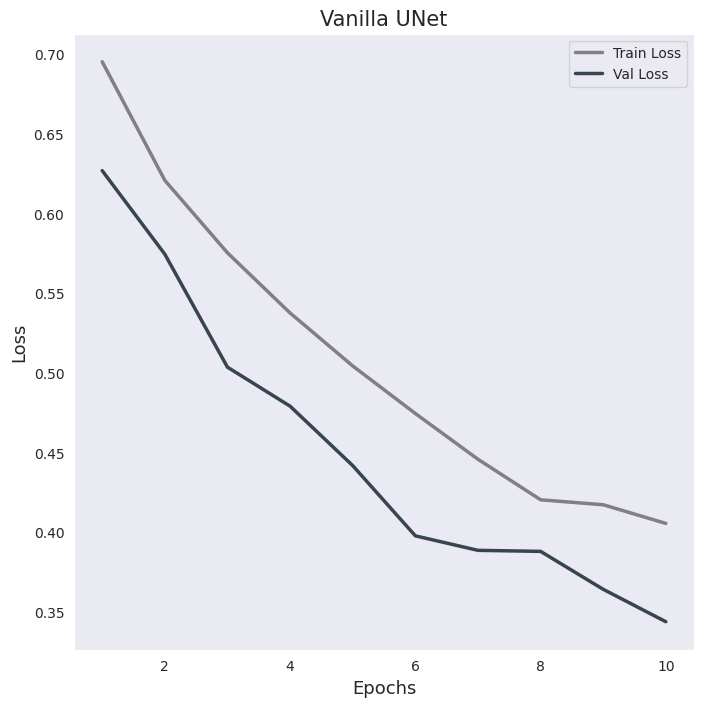


 Training completed in 3.0 h 19.0 m 30.45 s.


In [14]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 4, verbose = True, model_title = "Vanilla UNet", save = True,
             stopping_criterion = "loss")

In [15]:
torch.save(model.state_dict(), 'unet_final.pth')
print(f"Final model saved after {epochs+1} epochs.")

Final model saved after 11 epochs.


We validate the model on the test set using a custom fuction named `segmentation_test_loop`. We report the results on the test set with respect to the accuracy and the mean IoU. The variable `class_probs` shown below corresponds to the average probability for predicting the class $k$ for each $0\leq k \leq C-1$.

In [16]:
# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader, device = device)
class_report(target_names, scores, acc, jaccard, class_probs)

TypeError: StatScores.__new__() missing 1 required positional argument: 'task'

In [ ]:
visualize_preds(model, test_set, title = "Predictions - Vanilla UNet", save_title = "UNet", h = 12, w = 12, indices = [957,961,1476,1578])

## 3.3 UNet with Resnet encoder <a name="3.3"></a>

In this section we make use of transfer learning. We use a resnet model pretrained on imagenet for the encoder part of the UNet. The implemenation is taken by [segmentation models pytorch](https://github.com/qubvel/segmentation_models.pytorch).



In [ ]:
model = smp.Unet(encoder_name = "resnet50",
                encoder_weights = "imagenet",
                classes = 5).to(device)

In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 5, verbose = True, model_title = "UNet with Resnet encoder", save = True,
             stopping_criterion = "loss")

In [ ]:
# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                        device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

In [ ]:
visualize_preds(model, test_set, title = "Predictions - UNet+Resnet50",
               save_title = "UNet+Resnet", h = 12, w = 12, indices = [957,961,1476,1578])

## 3.4 DeepLabV3+ with Resnet encoder <a name="3.3"></a>

Now we try the state-of-the-art architecture on semantic segmentation - DeepLabV3+ [[3]](#ref3). Below you can see a visual representation of the architecture. 

<img src="https://github.com/ChrisNick92/Geospatial-Data/blob/main/Lab6/Images/deeplab.png?raw=true" width ="800" height = "600">
<br><br>

The atrous conv is the main operation of the model. It uses dilated convolution to capture the contextual information at multiple scales and it is really effective for high resolution images.

In [ ]:
model = smp.DeepLabV3Plus(encoder_name = "resnet50",
                         encoder_weights = "imagenet",
                         decoder_atrous_rates = (12,18,24),
                         encoder_output_stride =16,
                         classes = 5).to(device)

In [ ]:
# Training starts!
training_loop(model, train_dloader, val_dloader, epochs, lr, loss_fn, mod_epochs =1,
             regularization = "L2", reg_lambda = 1e-6, early_stopping = True,
             patience = 5, verbose = True, model_title = "DeepLabV3+ with Resnet encoder", save = True,
             stopping_criterion = "loss")

In [ ]:
# Evaluation - Accuracy + MIoU
scores, acc, jaccard, class_probs = segmentation_test_loop(model = model, test_loader = test_dloader,
                                        device = device)

class_report(target_names, scores, acc, jaccard, class_probs)

In [ ]:
visualize_preds(model, test_set, title = "Predictions - DeepLabV3+",
               save_title = "DeepLabV3+", h = 12, w = 12, indices = [957,961,1476,1578])

In [ ]:
# Delete the output folder
# from pathlib import Path
# import shutil
# OUTPUT_DIR = os.path.join(os.getcwd(), "output")

# if Path(OUTPUT_DIR).exists():
#     shutil.rmtree(OUTPUT_DIR)
#     print(f"Delete {OUTPUT_DIR} directory successfully")